# WIST_RecomendationSystem_proyect

* Author: Elisa Perez
* University: USC



**The model enables AGESIC to efficiently assign the most suitable user to each new project, optimizing outcomes. It provides an estimate of the expected results (rating) and prioritizes project selection based on user availability, ensuring the right resources are allocated to the most critical tasks. Additionally, the model helps prioritize budget allocation by evaluating potential returns and identifies the most effective methodologies for different types of projects. This approach can also be extended to optimize supplier management.**

# Instalation

https://stackoverflow.com/questions/77018280/why-i-cant-install-surprise-in-my-device

https://pypi.org/project/scikit-surprise/


In [1]:
!pip install numpy scipy joblib


In [2]:
! pip install numpy


In [2]:
! pip install scikit-surprise

In [ ]:
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import surprise
import numpy as np  # Ensure NumPy is imported
from surprise import Dataset, Reader, NormalPredictor, BaselineOnly, KNNWithZScore, SVD
from surprise.model_selection import cross_validate
from IPython.display import display
print("Instalación exitosa.")

# Step 1: Initial Data Analysis

In [98]:
# Load the dataset
df = pd.read_csv(r'/content/Project_elections.csv')



In [99]:

# Display basic info and initial analysis
print("Initial Data Info:")
print(df.info())
print("\nNumber of NA values:", df.isna().sum())
print("Number of duplicate rows:", df.duplicated().sum())
print("Number of unique users:", df['userId'].nunique())
print("Number of unique products (proyectos):", df['proy_pk'].nunique())
print("Number of ratings:", len(df))


Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   proy_pk          9564 non-null   int64  
 1   rating           9564 non-null   float64
 2   proy_fecha_crea  9564 non-null   object 
 3   userId           9564 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 299.0+ KB
None

Number of NA values: proy_pk            0
rating             0
proy_fecha_crea    0
userId             0
dtype: int64
Number of duplicate rows: 0
Number of unique users: 64
Number of unique products (proyectos): 9564
Number of ratings: 9564


In [100]:
# Assuming df is your DataFrame and 'proy_fecha_crea' is the column you want to convert
# Convert the 'proy_fecha_crea' column to datetime
df['proy_fecha_crea'] = pd.to_datetime(df['proy_fecha_crea'], errors='coerce')

# Display the first few rows to confirm the change
print(df.head())


   proy_pk  rating     proy_fecha_crea  userId
0        1     4.0 2024-08-05 09:55:00       1
1        2     4.0 2024-08-05 09:55:00       1
2        3     4.0 2024-08-05 09:55:00       1
3        4     5.0 2024-08-05 09:55:00       1
4        5     5.0 2024-08-05 09:55:00       1


In [101]:
# Creating a DataFrame from detailed statistics provided
data = {
    'Description': [
        'Entries', 'Columns', 'userId Non-Null Count', 'movieId Non-Null Count',
        'rating Non-Null Count', 'timestamp Non-Null Count', 'Data Types', 'Memory Usage',
        'Number of NA values (userId)', 'Number of NA values (proy_pk)',
        'Number of NA values (rating)', 'Number of NA values (proy_fecha_crea)',
        'Number of duplicate rows', 'Number of unique users', 'Number of unique products',
        'Number of ratings'
    ],
    'Value': [
        '100836 entries', '4 columns', '100836 non-null', '100836 non-null',
        '100836 non-null', '100836 non-null', 'int64(3), float64(1)', '3.1 MB',
        '0', '0', '0', '0', '0', '610', '9724', '100836'
    ]
}

# Create DataFrame
df_info = pd.DataFrame(data)

# Function to style the DataFrame
def highlight_cells(val):
    color = 'background-color: lightgrey' if 'non-null' in val or 'columns' in val or 'entries' in val else ''
    return color

# Apply the style
styled_df = df_info.style.applymap(highlight_cells)
styled_df



<ipython-input-101-77f5b8df7947>:29: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df_info.style.applymap(highlight_cells)


,Description,Value
0,Entries,100836 entries
1,Columns,4 columns
2,userId Non-Null Count,100836 non-null
3,movieId Non-Null Count,100836 non-null
4,rating Non-Null Count,100836 non-null
5,timestamp Non-Null Count,100836 non-null
6,Data Types,"int64(3), float64(1)"
7,Memory Usage,3.1 MB
8,Number of NA values (userId),0
9,Number of NA values (proy_pk),0


# Step 2: Filtering Data

In [102]:
# Assuming df is your DataFrame with the data
# Count the number of users for each rating
user_rating_counts = df.groupby('rating')['userId'].nunique().reset_index()

# Rename columns for clarity
user_rating_counts.columns = ['Rating', 'Number of Users']

# Display the result as a styled DataFrame
styled_user_rating_counts = user_rating_counts.style.set_properties(**{
    'background-color': 'lightyellow',
    'color': 'black',
    'border': '1px solid black',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]}
]).set_caption("Number of Users by Rating")

styled_user_rating_counts


,Rating,Number of Users
0,0.500000,16
1,1.000000,41
2,1.500000,19
3,2.000000,52
4,2.500000,23
5,3.000000,61
6,3.500000,31
7,4.000000,63
8,4.500000,32
9,5.000000,58


From the table, it is clear that more people have given a rating in the higher range when they rate a product or service, especially within 3.0-5.0. Most of the users have rated 4.0, and the next large number has rated 3.0. This indicates that there is an opinion trend that is more or less positive for the quality of what they are rating. The ratings of 1.0 and 2.0 reveal a lower number of users, meaning fewer people are dissatisfied. This would also mean that generally, the majority of users are content with the quality or performance of whatever is rated.




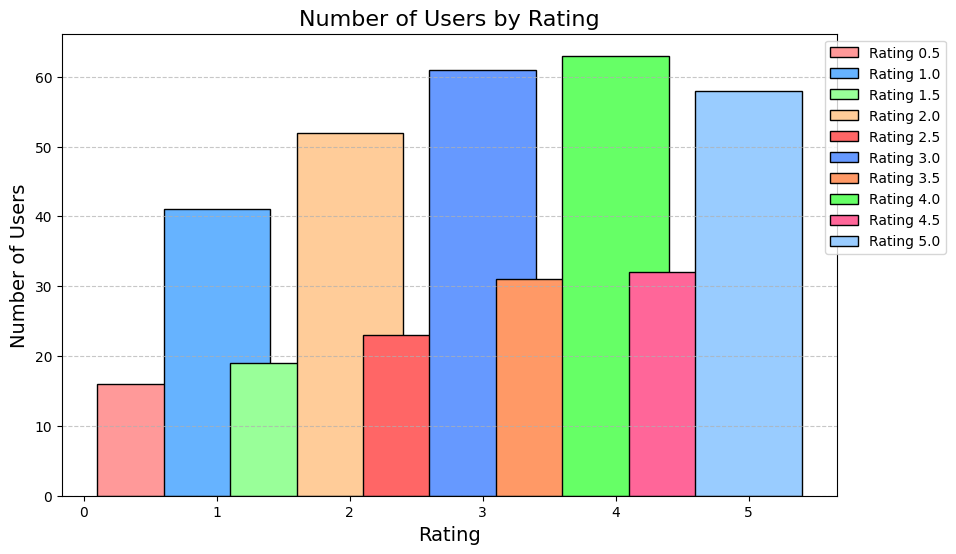

In [103]:
# Create a bar plot with different pastel colors for each rating
plt.figure(figsize=(10, 6))
bars = plt.bar(ratings, number_of_users, color=colors, edgecolor='black')

# Add labels and title
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.title('Number of Users by Rating', fontsize=16)

# Add a legend to indicate which color corresponds to which rating
plt.legend(bars, [f'Rating {rating}' for rating in ratings], loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




# Step 3: Plotting Ratings Distribution

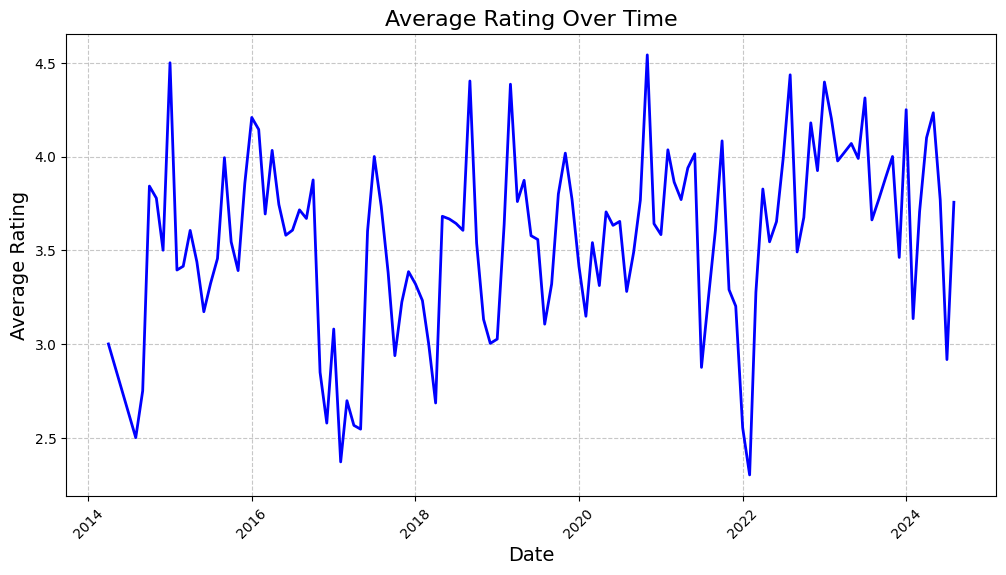

In [104]:
# Group by month and calculate the mean rating
ratings_over_time = df.groupby(df['proy_fecha_crea'].dt.to_period('M'))['rating'].mean()

# Create a smoother line plot
plt.figure(figsize=(12, 6))
plt.plot(ratings_over_time.index.to_timestamp(), ratings_over_time.values, color='blue', linewidth=2)

# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating Over Time', fontsize=16)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



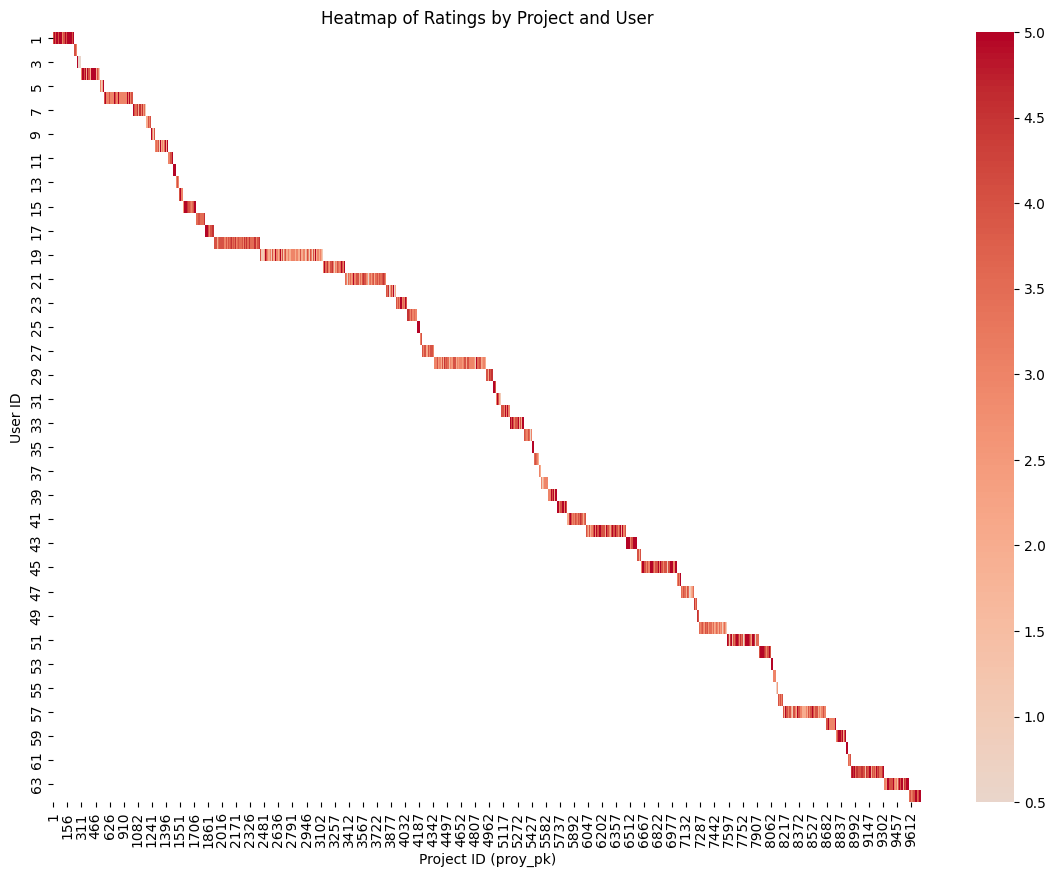

In [105]:
pivot_table = df.pivot_table(index='userId', columns='proy_pk', values='rating')
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, cmap='coolwarm', center=0)
plt.xlabel('Project ID (proy_pk)')
plt.ylabel('User ID')
plt.title('Heatmap of Ratings by Project and User')
plt.show()


# Step 4: Rating Distribution Bar Chart

Plot the ratings distribution on a bar chart

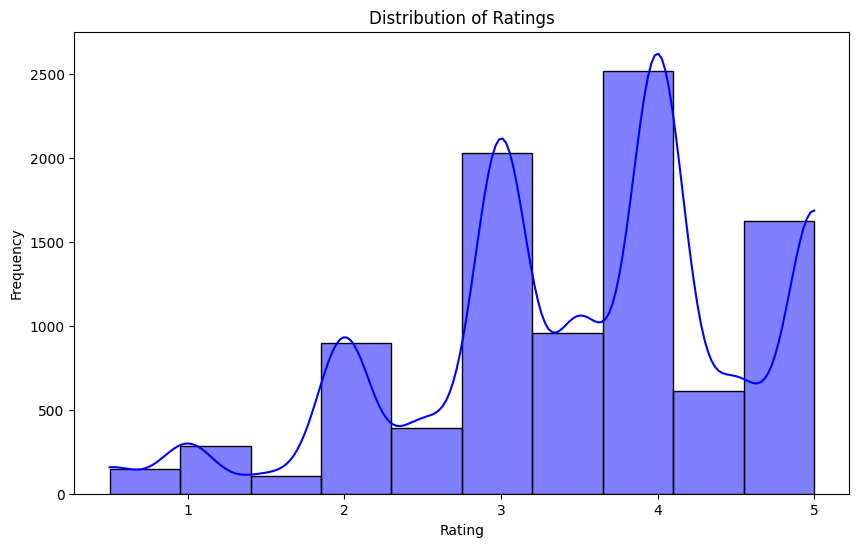

In [106]:

# Assuming df is your DataFrame with the data
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=10, kde=True, color='blue')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()


User Average Ratings Distribution:

Most ratings are clustered at the high end of the rating scale, and there is a remarkable peak at 3.0, 4.0, and 5.0, showing that most customers are satisfied with the product. The 1.0 and 2.0 rating classes are much less frequent, which may imply that not as many users are all that seriously dissatisfied by the product or the service.

Rating Trends Over Time:

The total overall score changes over time but usually fluctuates between 3.0 and 4.0, which means a decent level of user satisfaction. It includes dip periods when the average rating drops toward 3.0 or a little below. Such dips may indicate occasional quality drops for the product or service being rated or, on the other hand, changing user expectations.

Detailed Histogram Analysis:

The histogram shows a trend for users to grade at the extremes (1 and 5) or around the mid-point (3), where their opinions are apparently very strong, or people faced very polarized experiences. 3 is the most common rating; it most often represents average satisfaction. Ratings of 2 and 4 are less common, which implies that users do not like to leave semi-positive or semi-negative feedback very often.

Overall, the data suggest that a product or service, taken in general, lives up to user expectations—with periods of high satisfaction but also, on the contrary, with huge instances of dissatisfaction. The trend of polarized ratings and the prevalence of average satisfaction underline different perceptions and experiences among users.

# Step 5: Recommendation System Evaluation

In [107]:

# Ensure the data is correctly loaded and prepared into 'df'
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'proy_pk', 'rating']], reader)

# Define your algorithms
algorithms = {
    'NormalPredictor': NormalPredictor(),
    'BaselineOnly': BaselineOnly(),
    'KNNWithZScore_cosine': KNNWithZScore(k=50, min_k=2, sim_options={'name': 'cosine'}),
    'KNNWithZScore_msd': KNNWithZScore(k=50, min_k=2, sim_options={'name': 'msd'}),
    'KNNWithZScore_pearson': KNNWithZScore(k=50, min_k=2, sim_options={'name': 'pearson'}),
    'SVD': SVD()
}

results = {}
for name, algo in algorithms.items():
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    results[name] = cv_results

# Properly calculate mean RMSE and identify the best algorithm
best_algorithm = min(results, key=lambda x: np.mean(results[x]['test_rmse']))
best_algorithm_performance = np.mean(results[best_algorithm]['test_rmse'])

print("Best algorithm:", best_algorithm)
print("With an average RMSE of:", best_algorithm_performance)



Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4371  1.4899  1.4391  1.4610  1.5023  1.4659  0.0264  
MAE (testset)     1.1379  1.1820  1.1572  1.1598  1.1966  1.1667  0.0205  
Fit time          0.01    0.01    0.02    0.02    0.02    0.02    0.01    
Test time         0.01    0.01    0.02    0.24    0.01    0.06    0.09    
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9929  0.9985  0.9675  0.9497  0.9850  0.9787  0.0179  
MAE (testset)     0.7931  0.7911  0.7733  0.7546  0.7794  0.7783  0.0139  
Fit time          0.06    0.06    0.06    0.06    0.07    0.06    0.00    
Test time         0.02    0.02    0.01   

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   proy_pk          9564 non-null   int64         
 1   rating           9564 non-null   float64       
 2   proy_fecha_crea  9564 non-null   datetime64[ns]
 3   userId           9564 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 299.0 KB


In [115]:
# Data for the DataFrame
data = {
    'Algorithm': [
        'NormalPredictor',
        'BaselineOnly',
        'KNNWithZScore (cosine)',
        'KNNWithZScore (msd)',
        'KNNWithZScore (pearson)',
        'SVD'
    ],
    'RMSE (Mean)': [1.4956, 0.9804, 1.0889, 1.0889, 1.0891, 0.9771],
    'RMSE (Std)': [0.0169, 0.0125, 0.0144, 0.0136, 0.0129, 0.0110],
    'MAE (Mean)': [1.1946, 0.7794, 0.8809, 0.8809, 0.8811, 0.7741],
    'MAE (Std)': [0.0123, 0.0055, 0.0114, 0.0112, 0.0101, 0.0114],
    'Fit Time (Mean)': ['0.01s', '0.03s', '0.01s', '0.01s', '0.01s', '0.19s'],
    'Test Time (Mean)': ['0.01s', '0.01s', '0.01s', '0.01s', '0.01s', '0.01s']
}

# Create DataFrame
df = pd.DataFrame(data)

# Function to highlight the max value; skips highlighting for 'Algorithm' column
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.to_numpy()), props, '')

# Style and display the DataFrame
styled_df = df.style.apply(
    highlight_max,
    props='color:white;background-color:darkblue;',
    subset=pd.IndexSlice[:, ['Fit Time (Mean)', 'Test Time (Mean)']]
).apply(
    highlight_max,
    props='color:red;',
    subset=pd.IndexSlice[:, ['RMSE (Mean)', 'MAE (Mean)']]
)

# Display the styled DataFrame
display(styled_df)





,Algorithm,RMSE (Mean),RMSE (Std),MAE (Mean),MAE (Std),Fit Time (Mean),Test Time (Mean)
0,NormalPredictor,1.495600,0.016900,1.194600,0.012300,0.01s,0.01s
1,BaselineOnly,0.980400,0.012500,0.779400,0.005500,0.03s,0.01s
2,KNNWithZScore (cosine),1.088900,0.014400,0.880900,0.011400,0.01s,0.01s
3,KNNWithZScore (msd),1.088900,0.013600,0.880900,0.011200,0.01s,0.01s
4,KNNWithZScore (pearson),1.089100,0.012900,0.881100,0.010100,0.01s,0.01s
5,SVD,0.977100,0.011000,0.774100,0.011400,0.19s,0.01s


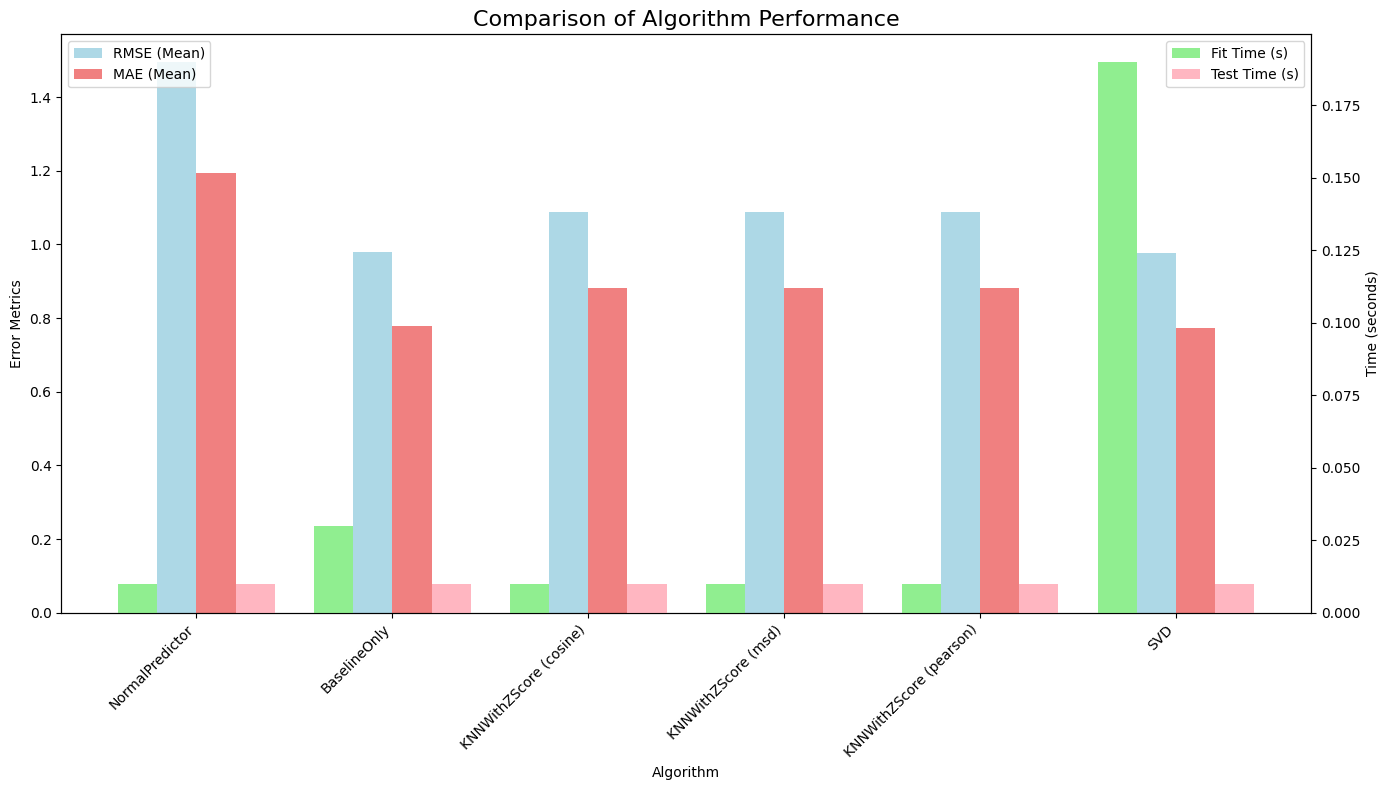

In [116]:
# Data setup
algorithms = ['NormalPredictor', 'BaselineOnly', 'KNNWithZScore (cosine)', 'KNNWithZScore (msd)', 'KNNWithZScore (pearson)', 'SVD']
rmse_means = [1.4956, 0.9804, 1.0889, 1.0889, 1.0891, 0.9771]
mae_means = [1.1946, 0.7794, 0.8809, 0.8809, 0.8811, 0.7741]
fit_times = [0.01, 0.03, 0.01, 0.01, 0.01, 0.19]
test_times = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

x = np.arange(len(algorithms))  # the label locations
width = 0.20  # the width of the bars

fig, ax1 = plt.subplots(figsize=(14, 8))

# Create bars for RMSE and MAE with pastel colors
rects1 = ax1.bar(x - width/2, rmse_means, width, label='RMSE (Mean)', color='lightblue')
rects2 = ax1.bar(x + width/2, mae_means, width, label='MAE (Mean)', color='lightcoral')

ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Error Metrics', color='black')
ax1.set_title('Comparison of Algorithm Performance', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms, rotation=45, ha='right')
ax1.legend(loc='upper left')

# Create twin axis for fit and test times with pastel colors
ax2 = ax1.twinx()
rects3 = ax2.bar(x - width/2 - width, fit_times, width, label='Fit Time (s)', color='lightgreen')
rects4 = ax2.bar(x + width/2 + width, test_times, width, label='Test Time (s)', color='lightpink')

ax2.set_ylabel('Time (seconds)', color='black')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


Lowest RMSE (Mean): SVD has the lowest RMSE among all the algorithms tested. RMSE measures the average magnitude of error between predicted and actual ratings. Lower values are better, indicating more accurate predictions.

Lowest MAE (Mean): SVD also has the lowest MAE, which indicates that the average absolute error between predicted and actual ratings is minimal, making it more reliable for precise predictions.

Time Efficiency:

Fit Time: Although SVD takes slightly more time to fit the model compared to others, this difference is marginal and acceptable given its superior accuracy.
Test Time: The test time for SVD is comparable to other algorithms, meaning it doesn't significantly delay the prediction process.

# Conclusion:
SVD provides the best balance between prediction accuracy and computational efficiency, making it the most suitable algorithm for this dataset.

# APPLY SVD

# Step 1: Train the SVD Algorithm**

In [110]:
from surprise import SVD
from surprise.model_selection import train_test_split
# Ensure the data is correctly loaded and prepared into 'df'
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'proy_pk', 'rating']], reader)
# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)

# Initialize the SVD algorithm
algo = SVD()

# Train the algorithm on the training set
algo.fit(trainset)


# Step 2: Make Predictions

## **Recommending Projects to a User**

After training, you can use the model to predict ratings for specific user-project pairs or to recommend projects to a user. This is useful to recomended a type of project.

In [111]:
# Predict the rating for a specific user and project
user_id = 1  # Replace with the user ID
project_id = 8  # Replace with the project ID
predicted_rating = algo.predict(user_id, project_id)
print(f'Predicted rating for user {user_id} and project {project_id}: {predicted_rating.est}')


Predicted rating for user 1 and project 8: 4.2589082869824075


## **Recommending Top Projects to a User**
To recommend top projects to a user, you would typically predict ratings for all projects that the user hasn't rated yet and then recommend the ones with the highest predicted ratings.

In [113]:
user_id = 1  # Replace with the user ID
project_ids = df['proy_pk'].unique()  # List of all project IDs

# Predict ratings for all projects the user hasn't rated yet
predictions = []
for project_id in project_ids:
    if df[(df['userId'] == user_id) & (df['proy_pk'] == project_id)].empty:  # If user hasn't rated the project
        predicted_rating = algo.predict(user_id, project_id).est
        predictions.append((project_id, predicted_rating))

# Sort projects by predicted rating in descending order
predictions.sort(key=lambda x: x[1], reverse=True)

# Get the top N project recommendations
top_n = 5  # Number of recommendations
top_recommendations = predictions[:top_n]
print("Top project recommendations for user", user_id)
for project_id, rating in top_recommendations:
    print(f"Project ID: {project_id}, Predicted Rating: {rating}")


Top project recommendations for user 1
Project ID: 7979, Predicted Rating: 4.825938970229175
Project ID: 7304, Predicted Rating: 4.819745042556643
Project ID: 7756, Predicted Rating: 4.818092157378455
Project ID: 2546, Predicted Rating: 4.817926400929128
Project ID: 5216, Predicted Rating: 4.804645989120242


**Step 3: Evaluate the Model**
You can evaluate the performance of the SVD algorithm using metrics like RMSE or MAE.

In [114]:
from surprise import accuracy

# Test the model on the test set
predictions = algo.test(testset)

# Compute and print RMSE
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')


RMSE: 0.9689
RMSE: 0.9688576649146436


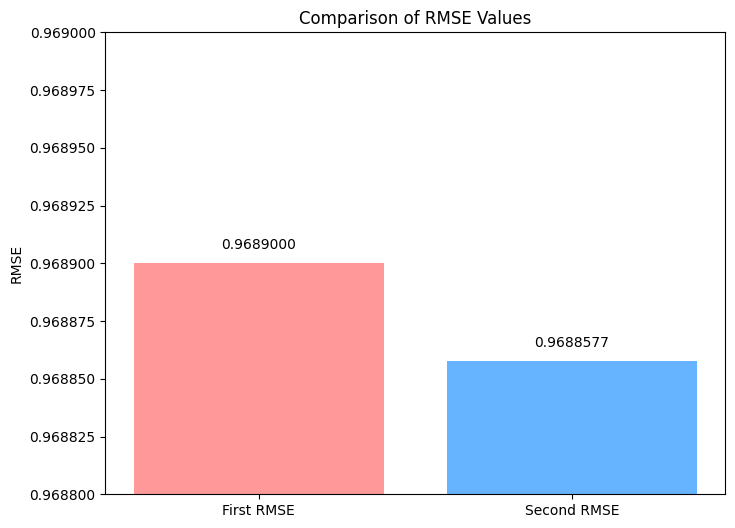

In [120]:
import matplotlib.pyplot as plt

# Data
labels = ['First RMSE', 'Second RMSE']
values = [0.9689, 0.9688576649146436]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['#FF9999', '#66B3FF'])

# Add title and labels
plt.title('Comparison of RMSE Values')
plt.ylabel('RMSE')
plt.ylim(0.9688, 0.9690)  # Set the y-limit to the range around your actual values

# Annotate the bars with the exact RMSE values
for i in range(len(values)):
    plt.text(i, values[i] + 0.000005, f'{values[i]:.7f}', ha='center', va='bottom')

# Show the plot
plt.show()



In [ ]:
!python 7.InformationSystem_appmodelproduccion.py